In [1]:
from Config.config import CONFIG
CONFIG = CONFIG("MOOC")

In [2]:
from DyGLib.models.GraphMixer import GraphMixer
from DyGLib.models.TGAT import TGAT
from DyGLib.models.TCL import TCL
from DyGLib.models.CAWN import CAWN
from DyGLib.models.DyGFormer import DyGFormer
from DyGLib.models.MemoryModel import MemoryModel, compute_src_dst_node_time_shifts

from DyGLib.models.modules import TGNN, NeuralNetworkSrcDst, BatchSubgraphs
from DyGLib.utils.DataLoader import get_link_prediction_data
from DyGLib.utils.utils import get_neighbor_sampler, NegativeEdgeSampler

import torch
import numpy as np
import pandas as pd
import seaborn as sns

import random

import graphviz
from IPython.display import SVG

# Initialization

In [3]:
trained_model_path = CONFIG.model.trained_model_path
edge_feat_path = CONFIG.data.folder + CONFIG.data.edge_feat_file
node_feat_path = CONFIG.data.folder + CONFIG.data.node_feat_file
index_path = CONFIG.data.folder + CONFIG.data.index_file
feature_names_path = CONFIG.data.folder + CONFIG.data.feature_names_file

In [4]:
# get data for training, validation and testing
node_raw_features, edge_raw_features, full_data, train_data, val_data, test_data = \
    get_link_prediction_data(val_ratio=0.1, test_ratio=0.1, node_dim=CONFIG.model.node_dim)

# initialize validation and test neighbor sampler to retrieve temporal graph
full_neighbor_sampler = get_neighbor_sampler(data=full_data, edge_features=edge_raw_features, sample_neighbor_strategy=CONFIG.model.sample_neighbor_strategy,
                                                time_scaling_factor=CONFIG.model.time_scaling_factor, seed=1)

# create model
if CONFIG.model.model_name == 'TGAT':
    dynamic_backbone = TGAT(num_nodes=node_raw_features.shape[0], node_dim=node_raw_features.shape[1], edge_dim=edge_raw_features.shape[1],
                            time_feat_dim=CONFIG.model.time_feat_dim, num_layers=CONFIG.model.num_layers, num_heads=CONFIG.model.num_heads, dropout=CONFIG.model.dropout, device=CONFIG.model.device)
elif CONFIG.model.model_name in ['JODIE', 'DyRep', 'TGN']:
    # four floats that represent the mean and standard deviation of source and destination node time shifts in the training data, which is used for JODIE
    src_node_mean_time_shift, src_node_std_time_shift, dst_node_mean_time_shift_dst, dst_node_std_time_shift = \
        compute_src_dst_node_time_shifts(train_data.src_node_ids, train_data.dst_node_ids, train_data.node_interact_times)
    dynamic_backbone = MemoryModel(num_nodes=node_raw_features.shape[0], node_dim=node_raw_features.shape[1], edge_dim=edge_raw_features.shape[1],
                                    time_feat_dim=CONFIG.model.time_feat_dim, model_name=CONFIG.model.model_name, num_layers=CONFIG.model.num_layers, num_heads=CONFIG.model.num_heads,
                                    dropout=CONFIG.model.dropout, src_node_mean_time_shift=src_node_mean_time_shift, src_node_std_time_shift=src_node_std_time_shift,
                                    dst_node_mean_time_shift_dst=dst_node_mean_time_shift_dst, dst_node_std_time_shift=dst_node_std_time_shift, device=CONFIG.model.device)
elif CONFIG.model.model_name == 'CAWN':
    dynamic_backbone = CAWN(num_nodes=node_raw_features.shape[0], node_dim=node_raw_features.shape[1], edge_dim=edge_raw_features.shape[1],
                            time_feat_dim=CONFIG.model.time_feat_dim, position_feat_dim=CONFIG.model.position_feat_dim, walk_length=CONFIG.model.walk_length,
                            num_walk_heads=CONFIG.model.num_walk_heads, dropout=CONFIG.model.dropout, device=CONFIG.model.device)
elif CONFIG.model.model_name == 'TCL':
    dynamic_backbone = TCL(num_nodes=node_raw_features.shape[0], node_dim=node_raw_features.shape[1], edge_dim=edge_raw_features.shape[1],
                            time_feat_dim=CONFIG.model.time_feat_dim, num_layers=CONFIG.model.num_layers, num_heads=CONFIG.model.num_heads,
                            num_depths=CONFIG.model.num_neighbors + 1, dropout=CONFIG.model.dropout, device=CONFIG.model.device)
elif CONFIG.model.model_name == 'GraphMixer':
    dynamic_backbone = GraphMixer(num_nodes=node_raw_features.shape[0], node_dim=node_raw_features.shape[1], edge_dim=edge_raw_features.shape[1],
                            time_feat_dim=CONFIG.model.time_feat_dim, num_tokens=CONFIG.model.num_neighbors, num_layers=CONFIG.model.num_layers, dropout=CONFIG.model.dropout, device=CONFIG.model.device)
elif CONFIG.model.model_name == 'DyGFormer':
    dynamic_backbone = DyGFormer(num_nodes=node_raw_features.shape[0], node_dim=node_raw_features.shape[1], edge_dim=edge_raw_features.shape[1],
                                    time_feat_dim=CONFIG.model.time_feat_dim, channel_embedding_dim=CONFIG.model.channel_embedding_dim, patch_size=CONFIG.model.patch_size,
                                    num_layers=CONFIG.model.num_layers, num_heads=CONFIG.model.num_heads, dropout=CONFIG.model.dropout,
                                    max_input_sequence_length=CONFIG.model.max_input_sequence_length, device=CONFIG.model.device)
else:
    raise ValueError(f"Wrong value for model_name {CONFIG.model.model_name}!")

regressor = NeuralNetworkSrcDst(input_dim=node_raw_features.shape[1], num_layers=CONFIG.model.num_reg_layers, hidden_dim=CONFIG.model.hidden_reg_layers_dim)
model = TGNN(dynamic_backbone, regressor)

The dataset has 411749 interactions, involving 7144 different nodes
The training dataset has 219769 interactions, involving 6170 different nodes
The validation dataset has 41174 interactions, involving 2062 different nodes
The test dataset has 41175 interactions, involving 1857 different nodes
The new node validation dataset has 20050 interactions, involving 1748 different nodes
The new node test dataset has 23731 interactions, involving 1640 different nodes
714 nodes were used for the inductive testing, i.e. are never seen during training


In [5]:
model.load_state_dict(torch.load(trained_model_path, weights_only=True))
model.to(CONFIG.model.device)
model.eval()

TGNN(
  (backbone): TGAT(
    (time_encoder): TimeEncoder(
      (w): Linear(in_features=1, out_features=100, bias=True)
    )
    (temporal_conv_layers): ModuleList(
      (0-1): 2 x MultiHeadAttention(
        (query_projection): Linear(in_features=272, out_features=272, bias=False)
        (key_projection): Linear(in_features=444, out_features=272, bias=False)
        (value_projection): Linear(in_features=444, out_features=272, bias=False)
        (layer_norm): LayerNorm((272,), eps=1e-05, elementwise_affine=True)
        (residual_fc): Linear(in_features=272, out_features=272, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (projectors): ModuleList(
      (0-1): 2 x Linear(in_features=444, out_features=172, bias=True)
    )
  )
  (model): NeuralNetworkSrcDst(
    (model): Sequential(
      (0): Linear(in_features=344, out_features=172, bias=True)
      (1): ReLU()
      (2): Linear(in_features=172, out_features=1, bias=True)
    )
  )
)

## Select edges

In [6]:
num_samples = 1000

In [7]:
def get_edge_by_id(link_index):
    src, dst, time_stamp, edge_id, true_value, label = full_data.src_node_ids[link_index], full_data.dst_node_ids[link_index], full_data.node_interact_times[link_index], full_data.edge_ids[link_index], 1, full_data.types[link_index] # type: ignore
    return src, dst, time_stamp, edge_id, true_value, label

In [8]:
random.seed(2025)

sampled_edge_ids = random.sample((np.where(~np.isnan(full_data.labels))[0]).tolist(), num_samples)

edge_info_array = np.array([list(get_edge_by_id(i)) for i in sampled_edge_ids])
edge_info = pd.DataFrame(edge_info_array, columns=["Src", "Dst", "Time", "Edge", "Target", "Label"])

edges = edge_info["Edge"].to_numpy(dtype=int)

edge_info["InTrain"] = np.isin(edges, train_data.edge_ids)
edge_info = edge_info.sort_values(by="InTrain").reset_index(drop=True)

srcs = edge_info["Src"].to_numpy(dtype=int)
dsts = edge_info["Dst"].to_numpy(dtype=int)
timestamps = edge_info["Time"].to_numpy(dtype=float)
targets = edge_info["Target"].to_numpy(dtype=float)
labels = edge_info["Label"].to_numpy()

In [9]:
model.eval()

subgraphs_src = full_neighbor_sampler.get_multi_hop_neighbors(CONFIG.model.num_layers, srcs, timestamps, num_neighbors = CONFIG.model.num_neighbors)
subgraphs_dst = full_neighbor_sampler.get_multi_hop_neighbors(CONFIG.model.num_layers, dsts, timestamps, num_neighbors = CONFIG.model.num_neighbors)
edge_feat_src = full_neighbor_sampler.get_edge_features_for_multi_hop(subgraphs_src[1])
edge_feat_dst = full_neighbor_sampler.get_edge_features_for_multi_hop(subgraphs_dst[1])

subgraphs_src = BatchSubgraphs(*subgraphs_src, edge_feat_src)
subgraphs_src.to(CONFIG.model.device)
subgraphs_dst = BatchSubgraphs(*subgraphs_dst, edge_feat_dst)
subgraphs_dst.to(CONFIG.model.device)

predicts = model(src_node_ids=srcs,
                dst_node_ids=dsts,
                node_interact_times=timestamps,
                src_subgraphs = subgraphs_src,
                dst_subgraphs = subgraphs_dst,
                time_gap=CONFIG.model.time_gap,
                edges_are_positive=True).squeeze(dim=-1)

edge_info["Prediction"] = predicts.detach().cpu().numpy()
edge_info.head(30)

,Src,Dst,Time,Edge,Target,Label,InTrain,Prediction
0,6364,7102,2525511.0,400410,1,0,False,0.034865
1,2173,7103,2135678.0,330379,1,0,False,1.125306
2,1034,7100,2188277.0,341584,1,0,False,-1.526560
3,314,7099,1280826.0,174852,1,0,False,3.220512
4,5023,7061,961893.0,132132,1,0,False,0.501081
5,395,7133,2454490.0,387809,1,0,False,0.472358
6,3746,7111,2361506.0,371674,1,0,False,1.194258
7,2747,7086,2455533.0,388217,1,0,False,0.439474
8,2091,7069,1831418.0,272915,1,0,False,2.750287
9,6743,7057,2169201.0,336735,1,0,False,0.465618


In [10]:
def draw_subgraph(edge_id, file_name = ""):
    dot = graphviz.Digraph(comment='computational graph')

    nodes_neighbor_ids_list, nodes_edge_ids_list, nodes_neighbor_times_list = full_neighbor_sampler.get_multi_hop_neighbors(CONFIG.model.num_layers,dsts[edge_id], timestamps[edge_id], num_neighbors=CONFIG.model.num_neighbors)

    edge_ids = np.hstack(nodes_edge_ids_list).flatten()
    edge_ids = edge_ids[edge_ids != 0]

    for e in edge_ids:
        if e != 0:
            s, d, ts, id, tv, l = get_edge_by_id(e)
            dot.node(str(s),str(s))
            dot.node(str(d),str(d))
            dot.edge(str(s), str(d), label=f"{l} ({id}) {int(ts)}")

    if(file_name != ""):
        dot.render(file_name, format="svg")
        SVG(filename=file_name + ".svg") 
    return dot


# First example

In [11]:
sample_edge = edge_info.iloc[[6]]
sample_edge_id = sample_edge.index

sample_edge

,Src,Dst,Time,Edge,Target,Label,InTrain,Prediction
6,3746,7111,2361506.0,371674,1,0,False,1.194258


In [12]:
draw_subgraph(sample_edge_id, "")

c:\Users\LMS\Documents\Masterarbeit\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 1/1 [00:01<00:00,  1.95s/it]


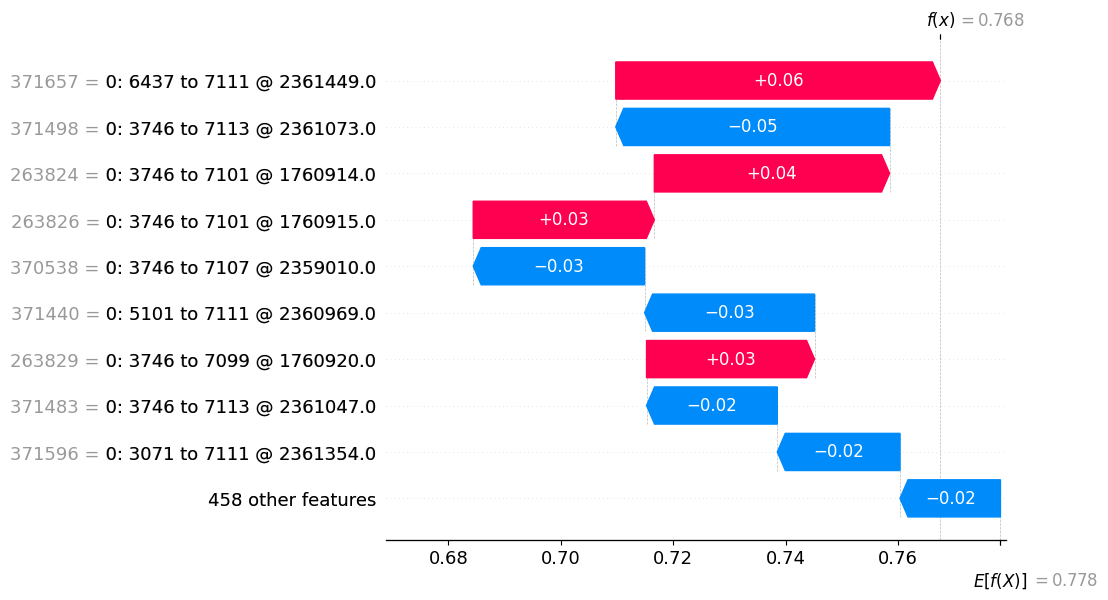

In [13]:
from Explainers.Shapley4TGNN.Explainer import ShapleyExplainerEvents
import shap
import matplotlib.pyplot as plt

explainer = ShapleyExplainerEvents(model, full_neighbor_sampler, full_data, edge_raw_features)
explainer.initialize()

shap_values = explainer.explain_instance(srcs[sample_edge_id[0]], dsts[sample_edge_id[0]], timestamps[sample_edge_id[0]]) # type: ignore
ax = shap.plots.waterfall(shap_values[1][0], show=False)
fig = ax.get_figure()
fig.savefig("Documents/Images/MOOC/Waterfall_edge-1.pdf", bbox_inches='tight')
plt.show()
explainer = None
torch.cuda.empty_cache()

Explain event: 100%|██████████| 3/3 [00:10<00:00,  3.55s/it]


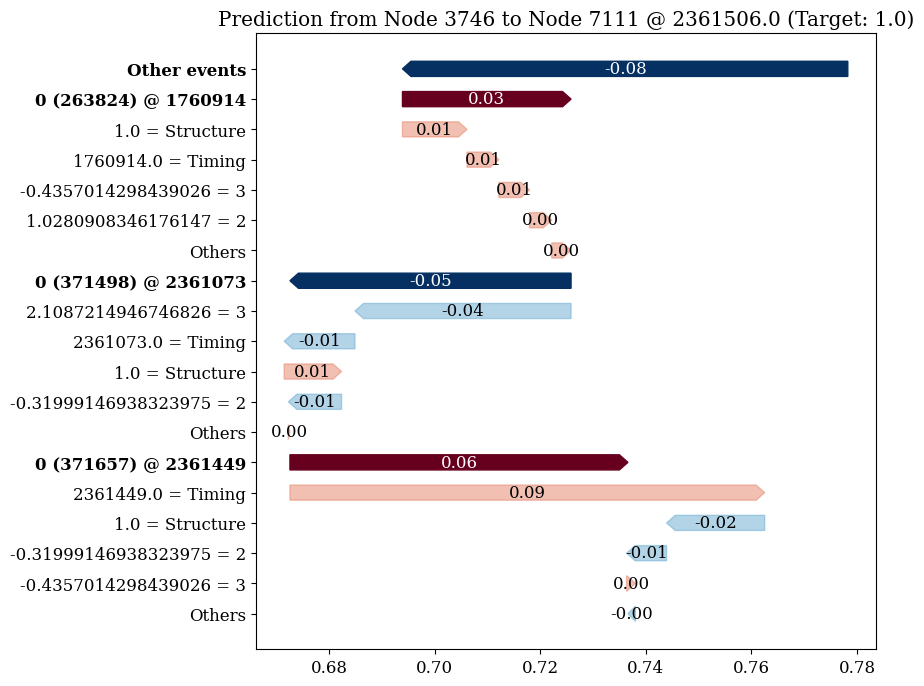

In [14]:
from Explainers.Shapley4TGNN.Explainer import ShapleyExplainerFeatures
from Explainers.Shapley4TGNN.Plots import waterfall
import shap
from shap import Explanation
import matplotlib 
font = {'size'   : 12, 'family':'serif'}
matplotlib.rc('font', **font)

explainer = ShapleyExplainerFeatures(model, full_neighbor_sampler, full_data, edge_raw_features, shapley_alg="MonteCarlo", top_k=3, feature_names=True)
explainer.initialize()
explanation_flatten, remaining_ids, remaining_shapley_values, baseline = explainer.explain_instance(srcs[sample_edge_id[0]], dsts[sample_edge_id[0]], timestamps[sample_edge_id[0]]) # type: ignore

fig = waterfall(explanation_flatten, baseline, 4, 
                src=srcs[sample_edge_id[0]], dst=dsts[sample_edge_id[0]], ts=timestamps[sample_edge_id[0]], target=targets[sample_edge_id[0]], 
                remaining_ids=remaining_ids,remaining_shapley_values=remaining_shapley_values)
fig.savefig("Documents/Images/MOOC/Waterfall_feat-1.pdf", bbox_inches='tight')
plt.show()

# Second example

In [15]:
sample_edge = edge_info.iloc[[19]]
sample_edge_id = sample_edge.index

sample_edge

,Src,Dst,Time,Edge,Target,Label,InTrain,Prediction
19,6347,7058,1883306.0,279014,1,0,False,1.714738


In [16]:
draw_subgraph(sample_edge_id, "")

100%|██████████| 1/1 [00:00<00:00,  1.31it/s]


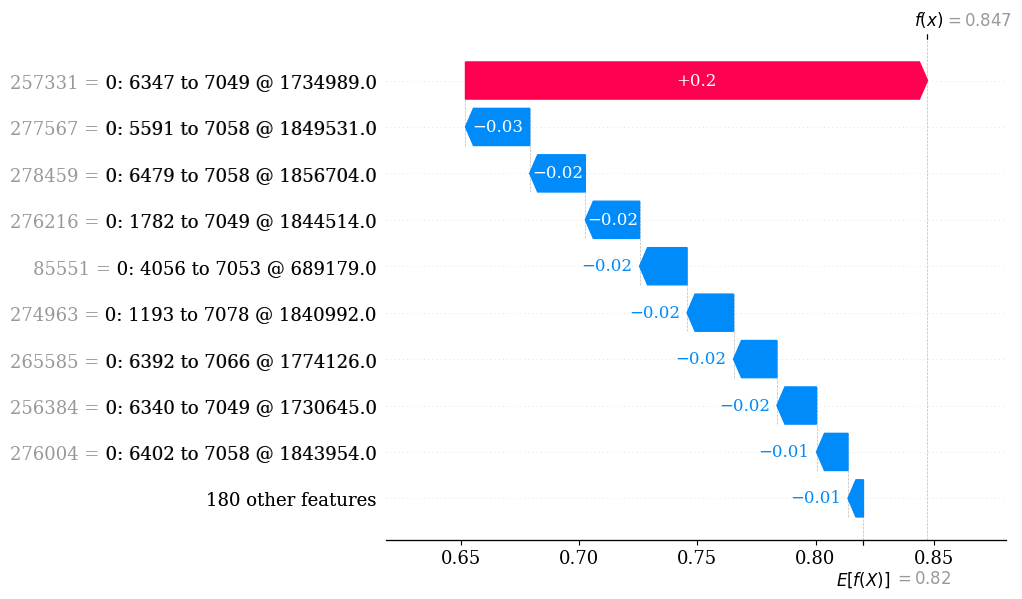

In [17]:
from Explainers.Shapley4TGNN.Explainer import ShapleyExplainerEvents
import shap
import matplotlib.pyplot as plt

explainer = ShapleyExplainerEvents(model, full_neighbor_sampler, full_data, edge_raw_features)
explainer.initialize()

shap_values = explainer.explain_instance(srcs[sample_edge_id[0]], dsts[sample_edge_id[0]], timestamps[sample_edge_id[0]]) # type: ignore
ax = shap.plots.waterfall(shap_values[1][0], show=False)
fig = ax.get_figure()
fig.savefig("Documents/Images/MOOC/Waterfall_edge-2.pdf", bbox_inches='tight')
plt.show()
explainer = None
torch.cuda.empty_cache()

Explain event: 100%|██████████| 3/3 [00:06<00:00,  2.31s/it]


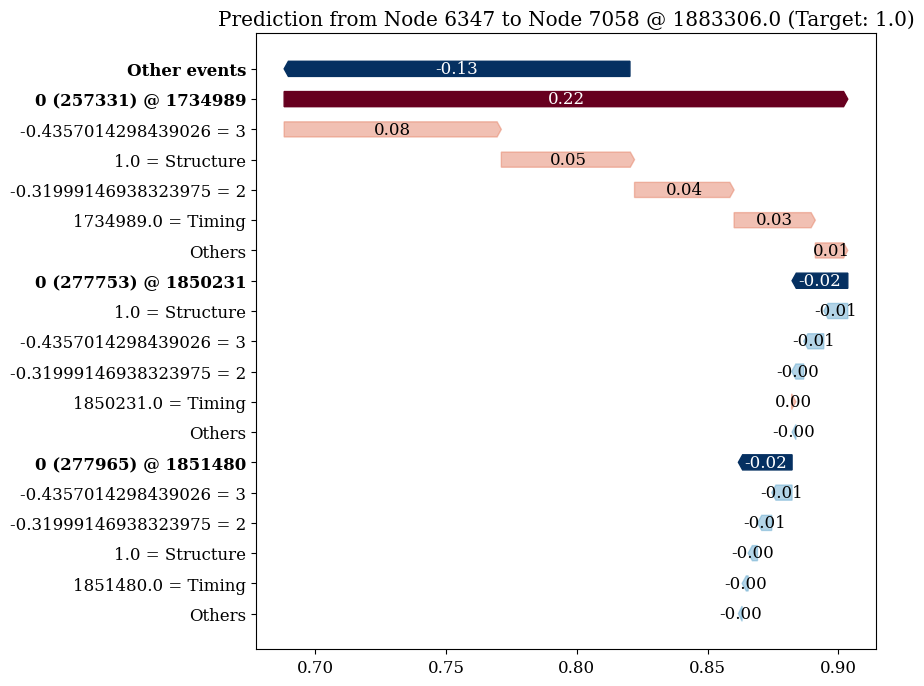

In [19]:
from Explainers.Shapley4TGNN.Explainer import ShapleyExplainerFeatures
from Explainers.Shapley4TGNN.Plots import waterfall
import shap
from shap import Explanation

explainer = ShapleyExplainerFeatures(model, full_neighbor_sampler, full_data, edge_raw_features, shapley_alg="MonteCarlo", top_k=3, feature_names=True)
explainer.initialize()
explanation_flatten, remaining_ids, remaining_shapley_values, baseline = explainer.explain_instance(srcs[sample_edge_id[0]], dsts[sample_edge_id[0]], timestamps[sample_edge_id[0]]) # type: ignore

fig = waterfall(explanation_flatten, baseline, 4, 
                src=srcs[sample_edge_id[0]], dst=dsts[sample_edge_id[0]], ts=timestamps[sample_edge_id[0]], target=targets[sample_edge_id[0]], 
                remaining_ids=remaining_ids,remaining_shapley_values=remaining_shapley_values)
fig.savefig("Documents/Images/MOOC/Waterfall_feat-2.pdf", bbox_inches='tight')
plt.show()